   ![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")

  <div align="left">Copyright (c) 2021, MBARI</div>

  * Distributed under the terms of the GPL License
  * Maintainer: ryjo@mbari.org
  * Author: John Ryan ryjo@mbari.org

## Blue whale song
---
Baleen whales produce rhythmic repeated sequences of sound; they sing.  This tutorial describes use of the *Pacific Ocean Sound Recordings* archive to examine temporal patterns of occurrence of blue whale song.  Signal processing methods focus on the blue whale B call.  A companion tutorial illustrates detection and classification of blue whale A calls using machine learning.

If you use this data set, please **[cite our project](https://ieeexplore.ieee.org/document/7761363).**


## Data Overview
---

### Recording site
The [recording site](https://www.mbari.org/at-sea/cabled-observatory/) is located on the continental slope of the eastern North Pacific, within [Monterey Bay National Marine Sanctuary](https://montereybay.noaa.gov/). The region is known to be [important foraging habitat](https://www.cascadiaresearch.org/publications/biologically-important-areas-selected-cetaceans-within-us-waters-%E2%80%93-west-coast-region) for the regional blue whale population.

### Hydrophone calibration
For the low-frequency (2 kHz) data, calibration data are not frequency dependent; a single low-frequency calibration value is used.  Its value depends on time of data collection, as two hydrophones have been deployed sequentially at the same site.  Before 14 June 2017, the calibration value is -168.8 dB re V / uPa (measured at 26 Hz).  After this date the value is -177.9 dB re V / uPa (measured at 250 Hz).  See also:


*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment01.json
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json

The first hydrophone exhibited calibration drift, while the second (deployed 13 June 2017 and currently operational) has not.  This observation is consistent with differences in the technologies of the two instruments.  However, for this application the calibration drift of the first hydrophone is not problematic because the CI is computed as a signal to noise ratio.  Therefore, time-series analysis of CI can reliably span the full archive.

### Data files and archive organization
The decimated audio data are in daily [WAV](https://en.wikipedia.org/wiki/WAV) files in an s3 bucket named <b>pacific-sound-2khz</b>, grouped by year and month.  Buckets are stored as objects, so the data are not physically stored in folders or directories as you may be famaliar with, but you can think of it conceptually as follows:

```
pacific-sound-2khz
      |
      ----2020
        |
        |----01
        ...
        |----12
```


## Install required dependencies

First, let's install the required software dependencies. 

If you are using this notebook in a cloud environment, select a Python3 compatible kernel and run this next section.  This only needs to be done once for the duration of this notebook.

If you are working on local computer, you can skip this next cell. Change your kernel to *pacific-sound-notebooks*, which you installed according to the instructions in the [README](https://github.com/mbari-org/pacific-sound-notebooks/) - this has all the dependencies that are needed. 

In [1]:
!pip install -q boto3 --quiet
!pip install -q soundfile --quiet
!pip install -q scipy --quiet
!pip install -q numpy --quiet
!pip install -q matplotlib --quiet

     |████████████████████████████████| 132 kB 3.9 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 9.1 MB 35.6 MB/s 
     |████████████████████████████████| 140 kB 49.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


### Import all packages

In [2]:
import boto3, botocore
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import scipy
from scipy import signal
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

## Data Access
---
This section covers file listing, metadata retrieval, and data loading.

### List files
Files are organized by year and month; list all of the files available for one month of one year.

In [3]:
s3 = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='',
    config=Config(signature_version=UNSIGNED))

In [4]:
year = 2016
month = 11
bucket = 'pacific-sound-2khz'

for obj in s3.list_objects_v2(Bucket=bucket, Prefix=f'{year:04d}/{month:02d}')['Contents']:
    print(obj['Key'])

2016/11/MARS-20161101T000000Z-2kHz.wav
2016/11/MARS-20161102T000000Z-2kHz.wav
2016/11/MARS-20161103T000000Z-2kHz.wav
2016/11/MARS-20161104T000000Z-2kHz.wav
2016/11/MARS-20161105T000000Z-2kHz.wav
2016/11/MARS-20161106T000000Z-2kHz.wav
2016/11/MARS-20161107T000000Z-2kHz.wav
2016/11/MARS-20161108T000000Z-2kHz.wav
2016/11/MARS-20161109T000000Z-2kHz.wav
2016/11/MARS-20161110T000000Z-2kHz.wav
2016/11/MARS-20161111T000000Z-2kHz.wav
2016/11/MARS-20161112T000000Z-2kHz.wav
2016/11/MARS-20161113T000000Z-2kHz.wav
2016/11/MARS-20161114T000000Z-2kHz.wav
2016/11/MARS-20161115T000000Z-2kHz.wav
2016/11/MARS-20161116T000000Z-2kHz.wav
2016/11/MARS-20161117T000000Z-2kHz.wav
2016/11/MARS-20161118T000000Z-2kHz.wav
2016/11/MARS-20161119T000000Z-2kHz.wav
2016/11/MARS-20161120T000000Z-2kHz.wav
2016/11/MARS-20161121T000000Z-2kHz.wav
2016/11/MARS-20161122T000000Z-2kHz.wav
2016/11/MARS-20161123T000000Z-2kHz.wav
2016/11/MARS-20161124T000000Z-2kHz.wav
2016/11/MARS-20161125T000000Z-2kHz.wav
2016/11/MARS-20161126T000

### Retrieve metadata
Read and show metadata for a single daily file.

In [5]:
year = 2016
month = 11
filename = 'MARS-20161101T000000Z-2kHz.wav'
bucket = 'pacific-sound-2khz'
key = f'{year:04d}/{month:02d}/{filename}'

url = f'https://{bucket}.s3.amazonaws.com/{key}'

sf.info(io.BytesIO(urlopen(url).read(1_000)), verbose=True)

samplerate: 2000 Hz
channels: 1
duration: 222 samples
format: WAV (Microsoft) [WAV]
subtype: Signed 24 bit PCM [PCM_24]
endian: FILE
sections: 1
frames: 222
extra_info: """
    Length : 1000
    RIFF : 518400324 (should be 992)
    WAVE
    fmt  : 16
      Format        : 0x1 => WAVE_FORMAT_PCM
      Channels      : 1
      Sample Rate   : 2000
      Block Align   : 3
      Bit Width     : 24
      Bytes/sec     : 6000
    LIST : 280
      INFO
        INAM : MBARI ocean audio data, start 20161101T000000 UTC
        ICMT : If you use these data, please cite https://doi.org/10.1109/OCEANS.2016.7761363. Recording metadata can be found at https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment01.json.
    data : 518400000 (should be 668)
    End
    """

### Load data
Read a single daily file.

In [6]:
# read full-day of data
print(f'Reading from {url}')
v, sample_rate = sf.read(io.BytesIO(urlopen(url).read()),dtype='float32')
v = v*3   # convert scaled voltage to volts
nsec = (v.size)/sample_rate # number of seconds in vector
print(f'Read {nsec} seconds of data')

Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161101T000000Z-2kHz.wav
Read 86400.0 seconds of data


## A view of blue whale song
---
To understand the method of quantifying song occurrence using an energy metric, it is useful to first consider the attributes of blue whale song.  Songs of the northeast Pacific blue whale population include three types of calls: A, B, and C.  The B calls have the strongest intensity and are thus often used to characterize song occurrence.

Analysis approaches include (1) detecting, classifying, and counting calls, and (2) quantifying the energy within the frequency band of the call, relative to that at background frequencies.  The first approach becomes difficult during periods when the whales chorus because the presence of overlapping calls thwarts distinction of individual calls.  The second approach can be applied consistently regardless of whether or not vocalizations overlap.  Application of this second approach to years of recordings, together with animal-borne metrics, revealed an [acoustic signature of blue whale migration](https://www.sciencedirect.com/science/article/pii/S0960982220313312).



:: psd.shape           = (1001, 86400)
:: f.size              = 1001
:: t.size              = 86400


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(1300, 20, 'fin whale calls')

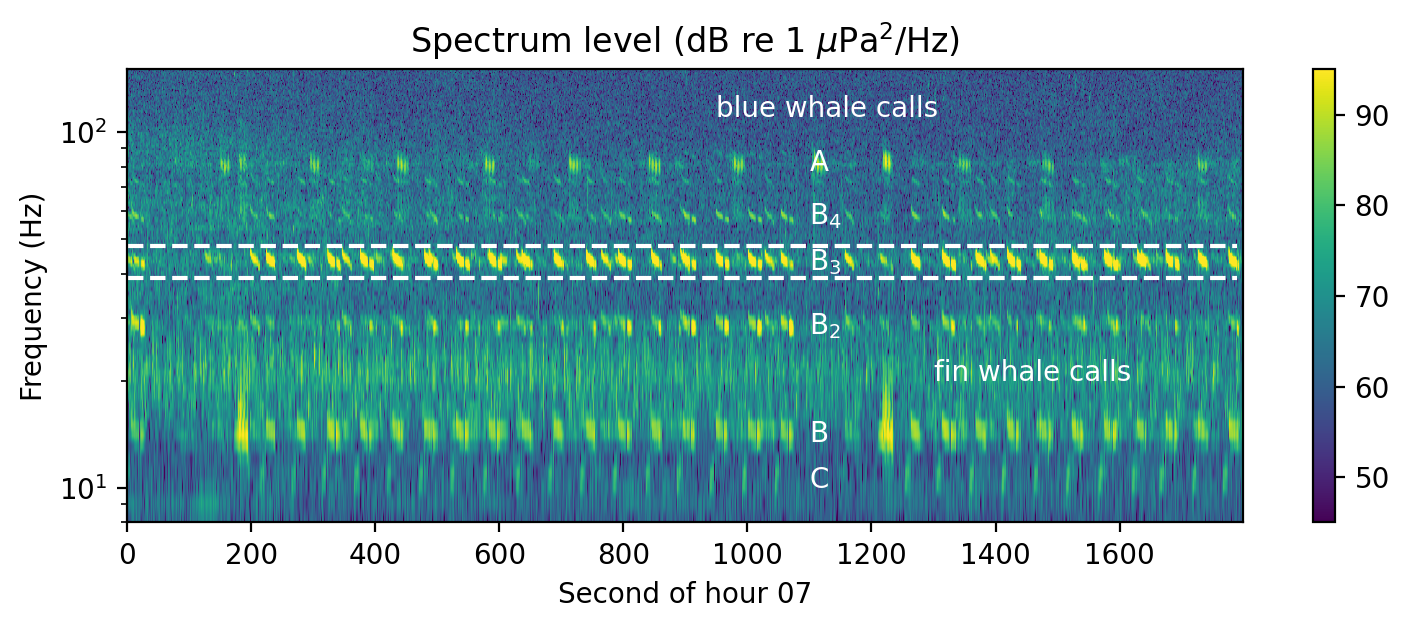

In [7]:
# Compute spectrogram
w = scipy.signal.get_window('hann',sample_rate)
f, t, psd = scipy.signal.spectrogram(v, sample_rate,nperseg=sample_rate,noverlap=0,window=w,nfft=sample_rate)
sens = -168.8  # hydrophone sensitivity at 26 Hz
psd = 10*np.log10(psd) - sens
print(f':: psd.shape           = {psd.shape}')
print(f':: f.size              = {f.size}')
print(f':: t.size              = {t.size}')

# Subset 30 minutes
start_hour = 7
start_sec = int(start_hour * 3600 + 1)
end_sec = start_sec+1800-1
psd_subset = psd[:,start_sec:end_sec]

# Plot
plt.figure(dpi=200, figsize = [9,3])
plt.imshow(psd_subset,aspect='auto',origin='lower',vmin=45,vmax=95)
plt.plot([1, 1790],[39, 39],'w--')
plt.plot([1, 1790],[48, 48],'w--')
plt.colorbar()
plt.ylim(8,150)
plt.yscale('log')
plt.xlabel('Second of hour 07')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrum level (dB re 1 $\mu$Pa$^2$/Hz)')
plt.annotate("C",(1100,10),color='w')
plt.annotate("B",(1100,13.5),color='w')
plt.annotate("B$_2$",(1100,27),color='w')
plt.annotate("B$_3$",(1100,41),color='w')
plt.annotate("B$_4$",(1100,55),color='w')
plt.annotate("A",(1100,78),color='w')
plt.annotate("blue whale calls",(950,110),color='w')
plt.annotate("fin whale calls",(1300,20),color='w')

In the spectrogram above, the whale call labels align with the frequency bands where the call energy occurs.  The third harmonic of the B call, within the frequency band defined by the dashed lines, carries the most energy and is the strongest signal for analysis.  Fin whale calls occurred throughout the time period shown, brief pulses with energy between the fundamental and second harmonic of the blue whale B calls.

## Call index
---
To consider the peak and background frequencies used in the calculation of call index, let's examine the average spectrum levels for period shown.

Text(0, 0.5, 'Frequency (Hz)')

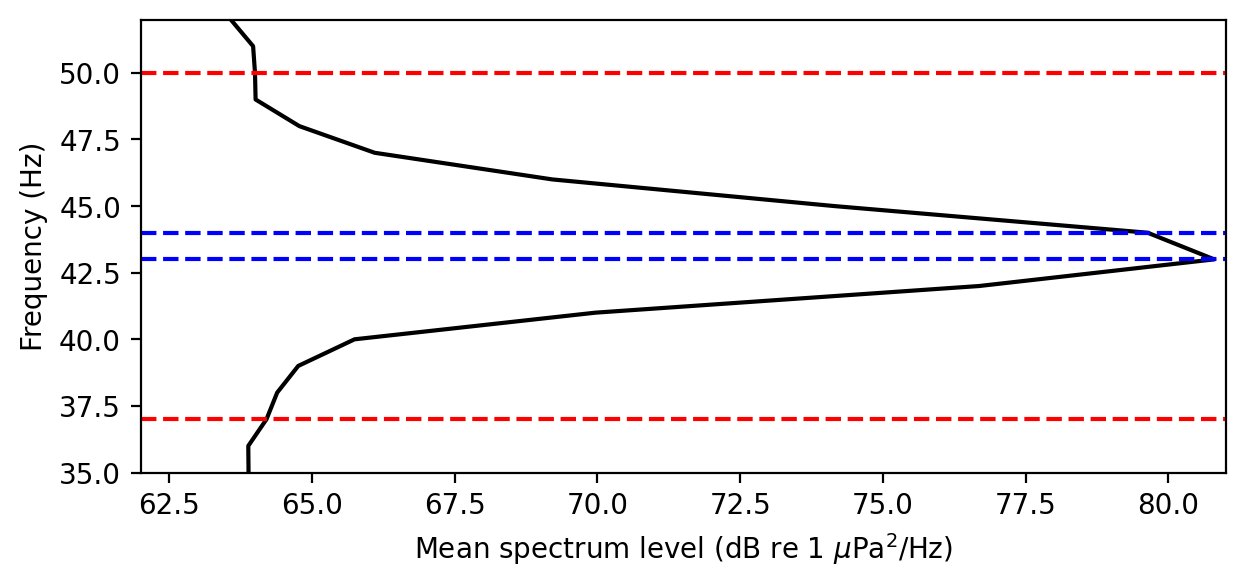

In [8]:
m = np.mean(psd_subset,axis=1)
plt.figure(dpi=200, figsize = [7,3])
plt.plot(m,f,'k')
plt.ylim(35,52)
plt.xlim(62,81)
plt.plot([62, 81],[43, 43],'b--')
plt.plot([62, 81],[44, 44],'b--')
plt.plot([62, 81],[37, 37],'r--')
plt.plot([62, 81],[50, 50],'r--')
plt.xlabel('Mean spectrum level (dB re 1 $\mu$Pa$^2$/Hz)')
plt.ylabel('Frequency (Hz)')
# cif.blue = [37 43 44 50];


The average energy within the peak caused by B calls (frequencies indicated by dashed blue lines) is much higher than the background (frequencies indicated by dashed red lines).  The call index (CI) is simply the ratio of signal (average spectrum level at the peak frequencies) to noise (average spectrum level at the background frequencies).  From the plot of average spectrum levels above, we can estimate a CI of approximately 1.25 for that time period.  To examine response of the index to individual calls, let's compute CI at 1-second resolution.

Text(0, 0.5, 'CI')

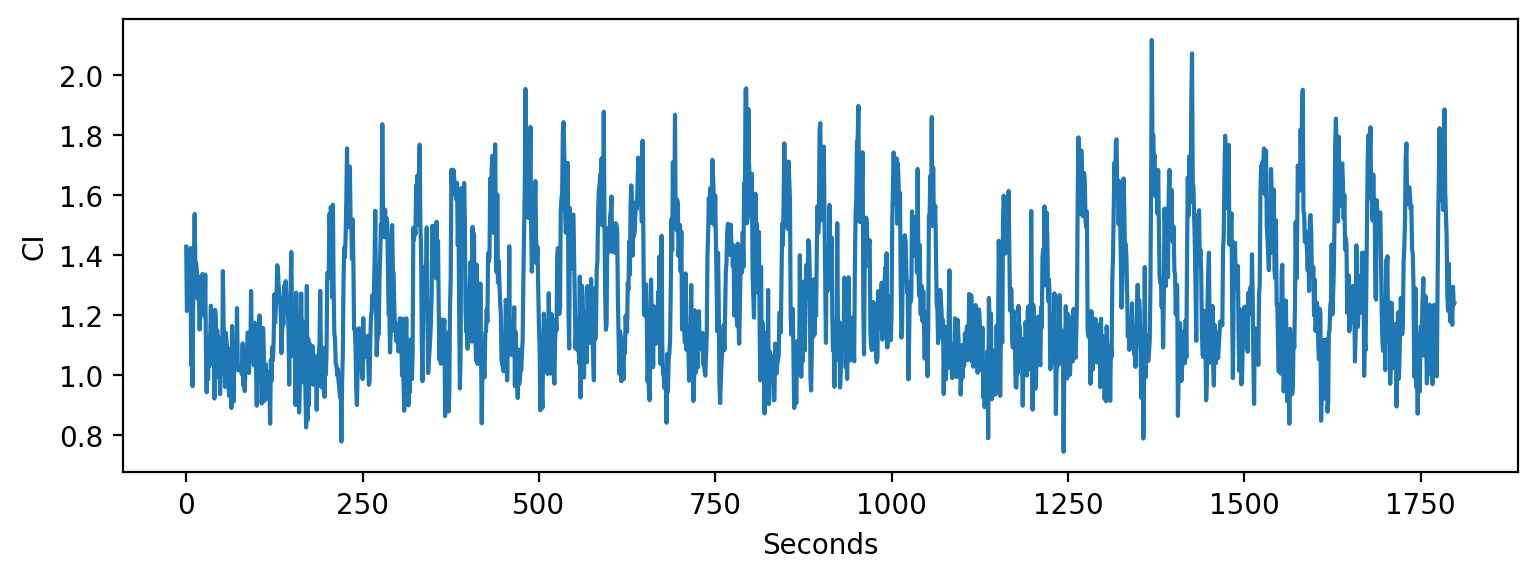

In [9]:
# find the frequencies of the peak and average spectrum levels
p1 = psd_subset[f==43]; p2 = psd_subset[f==44];
pk = np.squeeze(np.array([p1,p2]))
pk = np.mean(pk,axis=0); pk.shape
# plt.plot(pk)
# find the frequencies of the background and average
b1 = psd_subset[f==37]; b2 = psd_subset[f==50];
bg = np.squeeze(np.array([b1,b2]))
bg = np.mean(bg,axis=0); bg.shape
# plt.plot(pk/bg)
# CI
CI = pk/bg;
plt.figure(dpi=200, figsize = [9,3])
plt.plot(CI)
plt.xlabel('Seconds')
plt.ylabel('CI')

##Time-series analysis
---
Now that we have illustrated the methods of computing the call index, we can execute batch processing to extract time-series statistics.  The studies that motivated this tutorial examined six years of data.  For illustration purposes here, we'll produce daily statistics for the same month as the brief period examined above.

For time-series analysis, additional considerations for the methods arise.  The first is that the recording time-series contains gaps ranging from minutes to days.  Each daily 2 kHz file is fully populated (contains 1 day of data), and missing data periods are indicated by zero values.  Therefore, gaps can be identified as contiguous segments of data having zero values.  The second consideration is that blue whale B calls have a relatively long duration, thus computing power spectral density over periods longer than 1 second (as above) can be useful data reduction in time-series analysis.  Therefore, below we will use a 15-second window for psd calculation, and we will screen missing data periods.



In [10]:
# Determine the number of data files available for the month
num_files = 0
for obj in s3.list_objects_v2(Bucket=bucket, Prefix=f'{year}/{month}')['Contents']:
    print(obj['Key'])
    num_files = num_files+1

2016/11/MARS-20161101T000000Z-2kHz.wav
2016/11/MARS-20161102T000000Z-2kHz.wav
2016/11/MARS-20161103T000000Z-2kHz.wav
2016/11/MARS-20161104T000000Z-2kHz.wav
2016/11/MARS-20161105T000000Z-2kHz.wav
2016/11/MARS-20161106T000000Z-2kHz.wav
2016/11/MARS-20161107T000000Z-2kHz.wav
2016/11/MARS-20161108T000000Z-2kHz.wav
2016/11/MARS-20161109T000000Z-2kHz.wav
2016/11/MARS-20161110T000000Z-2kHz.wav
2016/11/MARS-20161111T000000Z-2kHz.wav
2016/11/MARS-20161112T000000Z-2kHz.wav
2016/11/MARS-20161113T000000Z-2kHz.wav
2016/11/MARS-20161114T000000Z-2kHz.wav
2016/11/MARS-20161115T000000Z-2kHz.wav
2016/11/MARS-20161116T000000Z-2kHz.wav
2016/11/MARS-20161117T000000Z-2kHz.wav
2016/11/MARS-20161118T000000Z-2kHz.wav
2016/11/MARS-20161119T000000Z-2kHz.wav
2016/11/MARS-20161120T000000Z-2kHz.wav
2016/11/MARS-20161121T000000Z-2kHz.wav
2016/11/MARS-20161122T000000Z-2kHz.wav
2016/11/MARS-20161123T000000Z-2kHz.wav
2016/11/MARS-20161124T000000Z-2kHz.wav
2016/11/MARS-20161125T000000Z-2kHz.wav
2016/11/MARS-20161126T000

###Single-day processing
First, define the standard daily processing steps.

1440 segments of length 60 seconds in 86400.0 seconds of audio
:: individual spectrogram shape   =   (1001, 1440)


Text(0.5, 1.0, 'Calibrated spectrum levels')

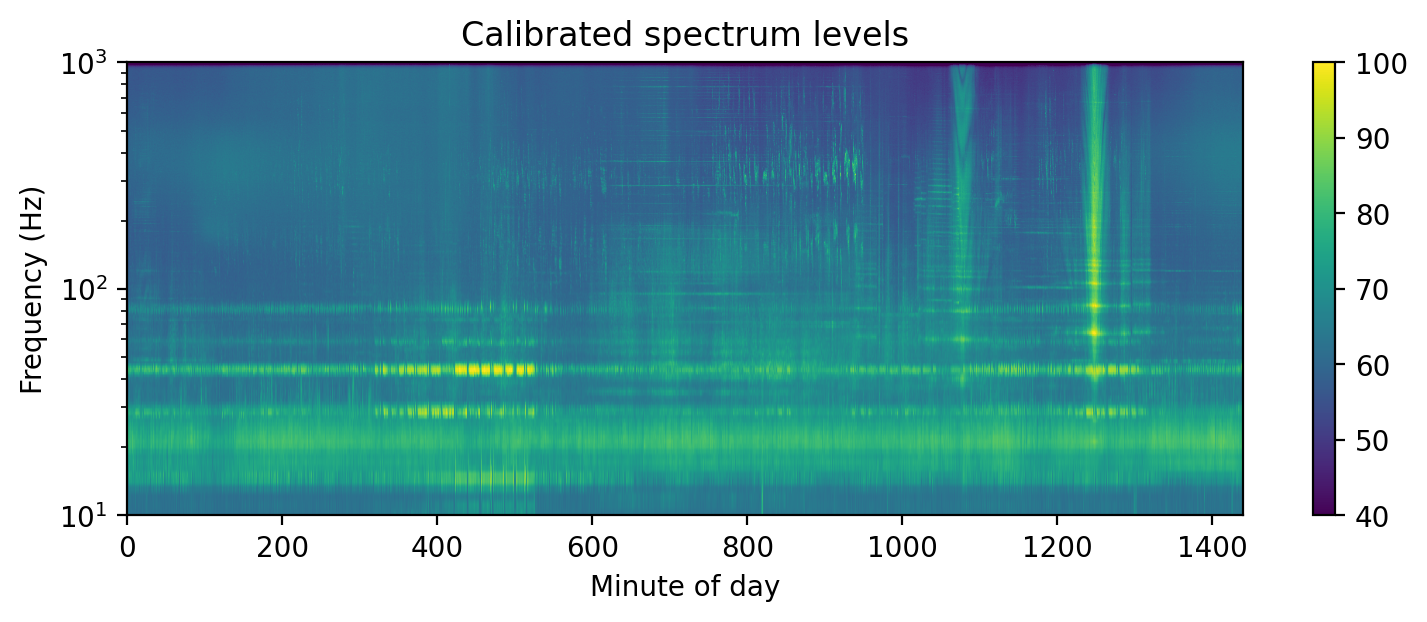

In [11]:
# define standard segment processing
w = scipy.signal.get_window('hann',sample_rate)
total_sec = v.size / sample_rate # total number of seconds in vector
spa = 60  # seconds per average
num_segments = int(total_sec/spa)
print(f'{num_segments} segments of length {spa} seconds in {total_sec} seconds of audio')

# initialize empty spectrogram
nyquist_freq = int(sample_rate/2+1)
sg = np.empty((nyquist_freq, num_segments), float)
print(f':: individual spectrogram shape   =   {sg.shape}')

# process spectrogram, capturing number of zero values in data
for x in range(0,num_segments):
  cstart = x*spa*sample_rate; cend = (x+1)*spa*sample_rate
  cv = v[cstart:cend]
  f,psd = scipy.signal.welch(cv,fs=sample_rate,window=w,nfft=sample_rate)
  psd = 10*np.log10(psd) - sens
  sg[:,x] = psd

# plot spectrogram for example day
plt.figure(dpi=200, figsize = [9,3])
plt.imshow(sg,aspect='auto',origin='lower',vmin=40,vmax=100)
plt.yscale('log')
plt.ylim(10,1000)
plt.colorbar()
plt.xlabel('Minute of day')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')

In the frequency band of the B-call third harmonic, just above 40 Hz, we can see calls present throughout the day, with greatest intensity between ~ minutes 400 and 600.

To consider day-to-day variability, let's process a month of data, representing mean CI for each day.  We will still process in 1-minute segments, which allows us to identify periods of missing data and exclude them from analysis.

In [12]:
# Batch process the month of daily files
F = -1   # first row index will be 0 after increment
spa = 60  # seconds per average
num_segments = int(86400/spa)   # number of processing segments
# Initialize arrays to hold CI and zero count results
# dimensions: number of days x number of segments per day
CIm = np.zeros((num_files,num_segments))
zero_count = np.zeros((num_files,num_segments))

sample_rate = 2000   # data sample rate
w = scipy.signal.get_window('hann',sample_rate)   # 1-second window for 2 kHz data
nyquist_freq = int(sample_rate/2+1)   # number of output frequencies in spectrogram

for obj in s3.list_objects_v2(Bucket=bucket, Prefix=f'{year}/{month}')['Contents']:
  F = F+1
  # read file
  filename = obj['Key']
  url = f'https://{bucket}.s3.amazonaws.com/{filename}'
  print(f'Reading from {url}')
  v, fs = sf.read(io.BytesIO(urlopen(url).read()),dtype='float32')
  v = v*3   # convert scaled voltage to volts

  # initialize empty spectrogram
  sg = np.empty((nyquist_freq, num_segments), float)

  # process spectrogram, capturing number of zero values in data
  for x in range(0,num_segments):
    cstart = x*spa*fs; cend = (x+1)*spa*fs; cv = v[cstart:cend]
    f,psd = scipy.signal.welch(cv,fs,window=w,nfft=fs)
    psd = 10*np.log10(psd) - sens
    sg[:,x] = psd
    zero_count[F,x] = (cv == 0).sum(0)

  # CI
  # find the frequencies of the peak and average spectrum levels
  p1 = sg[f==43]; p2 = sg[f==44];
  pk = np.squeeze(np.array([p1,p2]))
  pk = np.mean(pk,axis=0);
  # find the frequencies of the background and average
  b1 = sg[f==37]; b2 = sg[f==50];
  bg = np.squeeze(np.array([b1,b2]))
  bg = np.mean(bg,axis=0);

  # CI
  CIm[F,:] = pk/bg;

Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161101T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161102T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161103T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161104T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161105T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161106T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161107T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161108T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161109T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161110T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161120T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161121T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161122T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161123T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161124T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161125T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161126T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161127T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161128T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2016/11/MARS-20161129T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.

Viewing the arrays containing 1-minute CI and missing data counts.

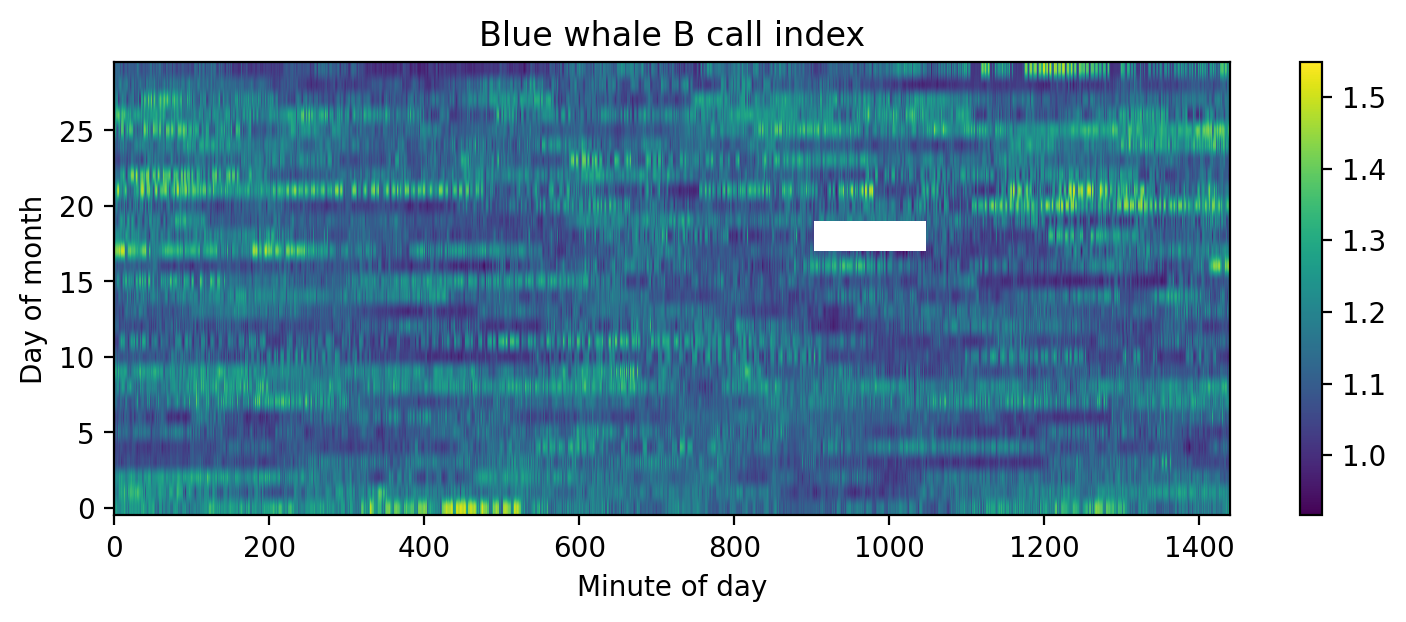

In [13]:
plt.figure(dpi=200, figsize = [9,3])
plt.imshow(CIm,aspect='auto',origin='lower')
plt.xlabel('Minute of day')
plt.ylabel('Day of month')
plt.title('Blue whale B call index')
plt.colorbar()

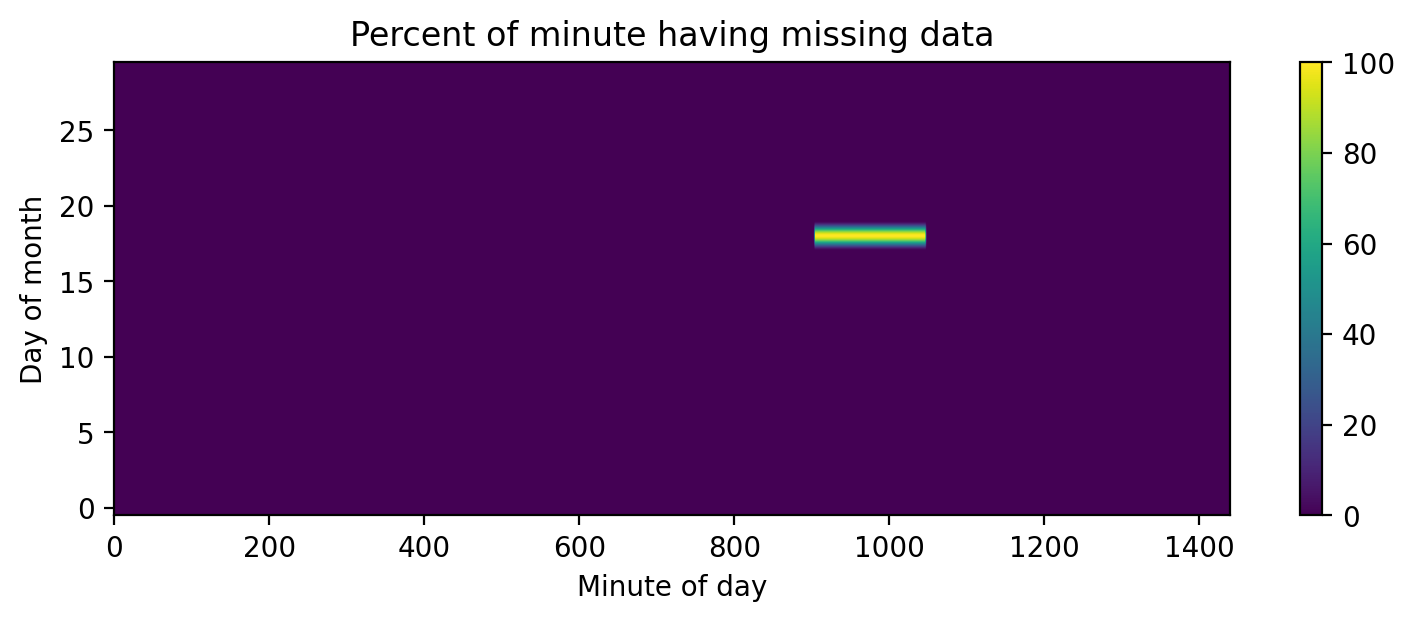

In [14]:
plt.figure(dpi=200, figsize = [9,3])
percent_missing = 100*zero_count/(spa*sample_rate)
plt.imshow(percent_missing,aspect='auto',origin='lower')
plt.xlabel('Minute of day')
plt.ylabel('Day of month')
plt.title('Percent of minute having missing data')
plt.colorbar()

Missing data occurred on only one day this month.  We'll screen the missing data period in computing daily means.

In [15]:
CImean = np.mean(CIm, axis = 1); CImean

array([1.21468493, 1.16479025, 1.15670388, 1.1050407 , 1.11908176,
       1.10882629, 1.10125856, 1.1627475 , 1.20047926, 1.1548656 ,
       1.09833866, 1.1261652 , 1.09979253, 1.10988589, 1.13624584,
       1.12415737, 1.1106124 , 1.15430699,        nan, 1.13311153,
       1.14972755, 1.2056214 , 1.16504154, 1.15328517, 1.15539602,
       1.20114181, 1.18342288, 1.15568718, 1.08687578, 1.11712618])

Means are computed for all days except the one with missing data.

In [16]:
CImean[18]

nan

Isolate the valid 1-minute CI values for this day.

In [17]:
c = CIm[18,]; p = percent_missing[18,];
# Limit valid CI to minutes with < 1% of data missing
c = c[p < 1]
CImean[18] = np.mean(c)

Text(0, 0.5, 'Mean CI')

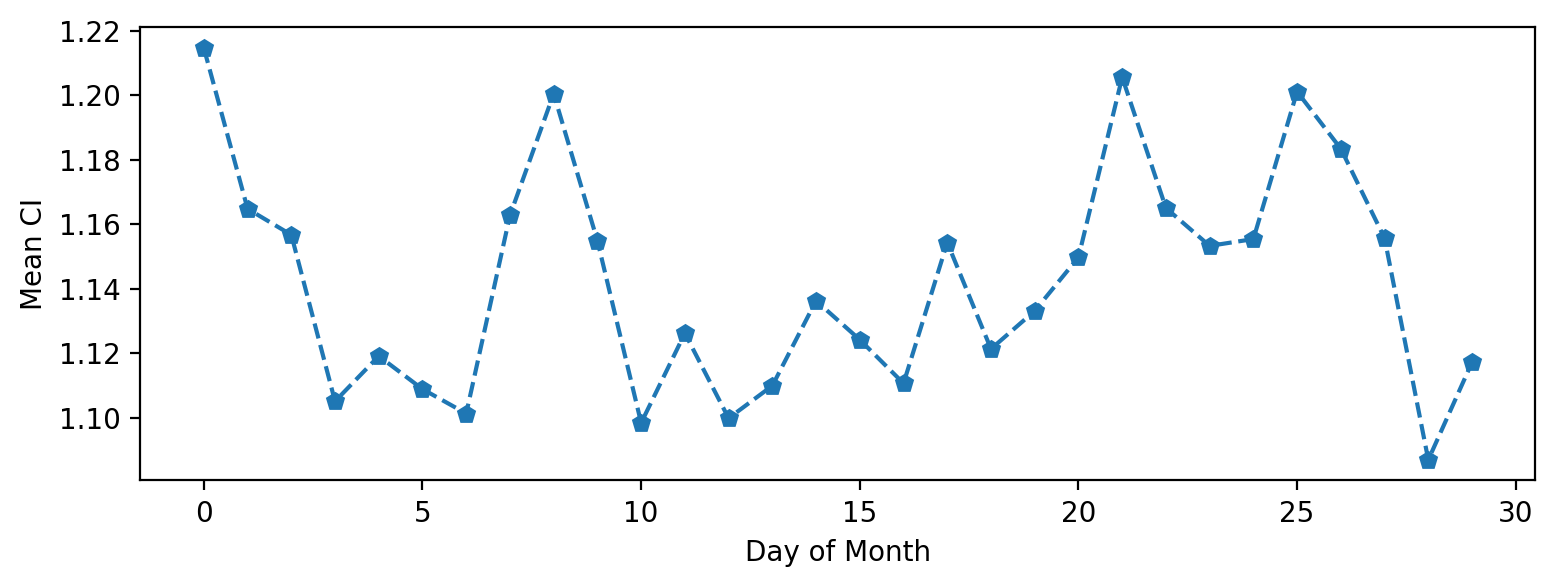

In [18]:
plt.figure(dpi=200, figsize = [9,3])
plt.plot(CImean,'--p')
plt.xlabel('Day of Month')
plt.ylabel('Mean CI')